In [241]:
!pip install fitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [10]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
from sympy.plotting import plot
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import sympy
from sympy import symbols, exp, oo
from sympy.functions.elementary.complexes import sign
from fitter import Fitter

In [2]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# 比赛人数模型

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

Text(0.5, 1.0, 'laplace_asymmetric(kappa=0.51, loc=100.00, scale=83.32)')

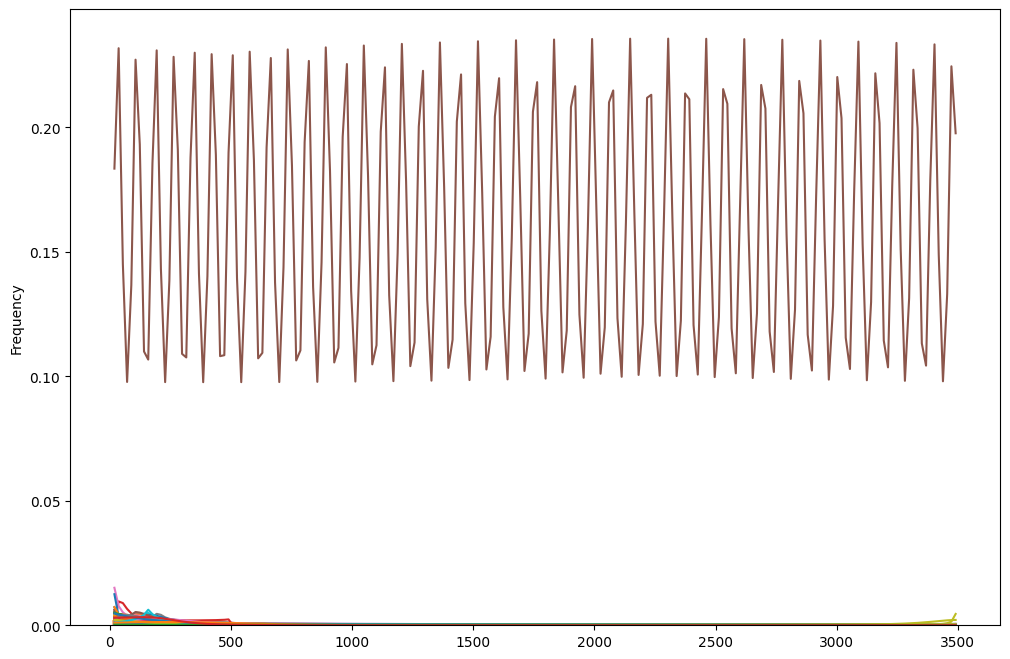

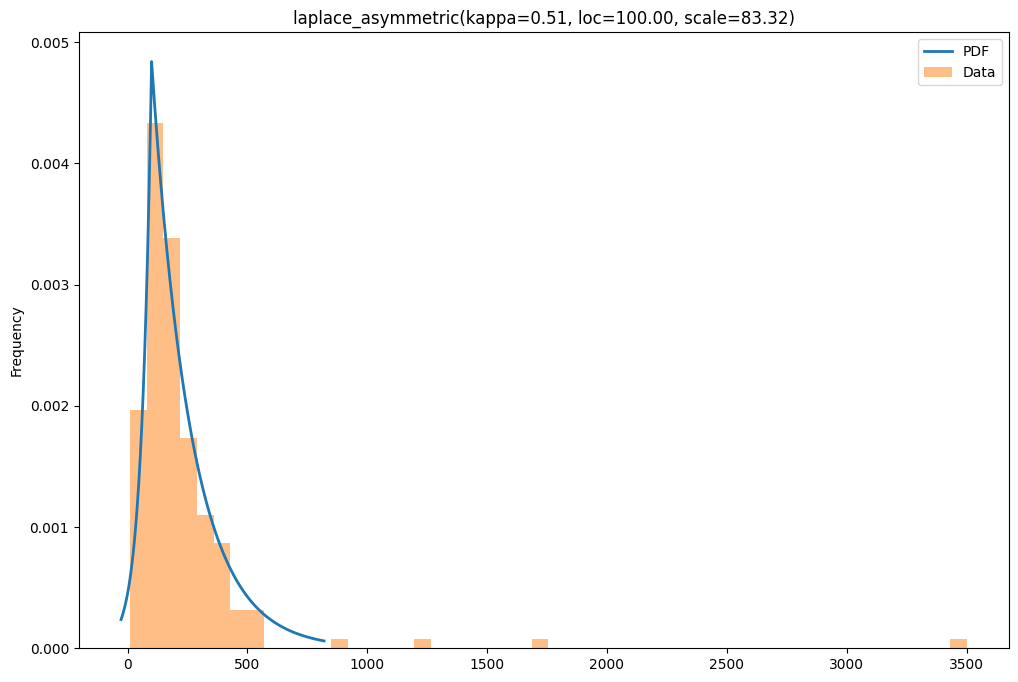

In [204]:
df = pd.read_csv('data.csv')

def numberic(x):
    if type(x) is str and '-' in x:
        a, b = x.split('-')
        a, b = int(a), int(b)
        return (a + b) / 2
    elif type(x) is str:
      return int(''.join(c for c in x if c.isdigit()))
    else:
      return x

# Clean up data
data = pd.Series([numberic(x) for x in df['参赛人数']])
data = data[data.notnull()]

# Remove outlier
# data = data[np.abs(stats.zscore(data)) < 3]

# # Plot original
# ax = data.hist(bins=20, grid=False)
# ax.set_xlim(0, 500)
# plt.xticks(np.arange(0, 500, 50))
# ax.plot()

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(dist_str)


可得，2023年比赛人数分布近似为**非对称拉普拉斯分布**。参数为

```
κ = 0.1
𝒎 = 100
λ = 83.32
```

$$
f(x; m,\lambda,\kappa)=(\frac{1}{\kappa+\kappa^{-1}}) e^{-sy\kappa^{s}}, y = \frac{x-m}{\lambda}, s=sgn(y)
$$

In [31]:
kappa = 0.51
loc = 100
scale = 83.32

dist = st.laplace_asymmetric(kappa = kappa, loc = loc, scale = scale)
mean = dist.expect()
print(mean)

220.87934900297162


每场参赛人数数学期望约 221 人

In [32]:
x = symbols('x') # x为人数

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace_asymmetric.html#scipy.stats.laplace_asymmetric
y = (x - loc) / scale
s = sign(y)
f_number_of_participants = (1 / (kappa + 1 / kappa)) * exp(-s * y * kappa ** s) / scale

f_number_of_participants

0.00485753460574325*exp(-0.51**sign(0.0120019203072492*x - 1.20019203072492)*(0.0120019203072492*x - 1.20019203072492)*sign(0.0120019203072492*x - 1.20019203072492))

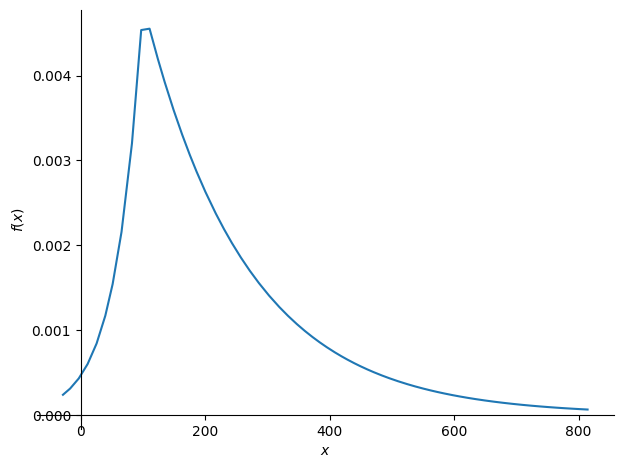

In [207]:
from sympy.plotting import plot
min = st.laplace_asymmetric.ppf(0.01, kappa, loc = loc, scale = scale)
max = st.laplace_asymmetric.ppf(0.99, kappa, loc = loc, scale = scale)
plot(f_number_of_participants, (x, min, max), nb_of_points=4000)

In [208]:
# 比赛500人以下的概率约为 93%
sympy.integrate(f_number_of_participants, (x, -10000, 500))

0.931408237084122

# 每日比赛场次

2024-02-26 05:18:54.635 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-02-26 05:18:54.739 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=81.813144)
2024-02-26 05:18:54.990 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=45.199166)
2024-02-26 05:18:55.126 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=74.5931)
2024-02-26 05:18:55.323 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=83.578876)
2024-02-26 05:18:55.881 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=57.056046)
2024-02-26 05:18:55.930 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted betaprime distribution with error=77.65331)
2024-02-26 05:18:56.273 | INFO     | fitter.fitter:_fit_single_distribution:337

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,34.466698,1016.159383,1028.201924,inf,0.493682,2.861906e-34
alpha,45.199166,836.567093,845.598999,inf,0.444115,1.759126e-27
halfgennorm,46.241237,653.226261,662.258167,inf,0.374746,2.003307e-19
weibull_min,51.352367,600.785349,609.817254,inf,0.473333,2.255566e-31
truncweibull_min,52.443586,499.305335,514.358512,inf,0.473255,2.312612e-31


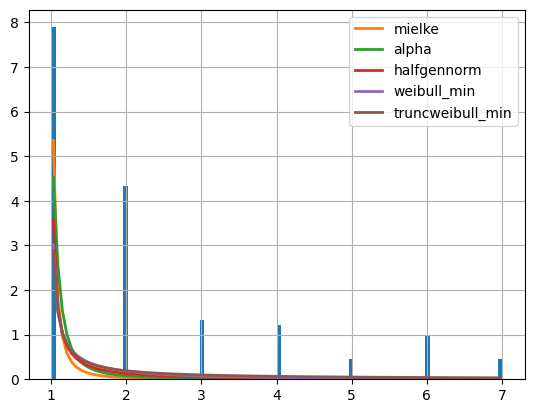

In [17]:
df = pd.read_csv('data.csv', parse_dates=['结束日期'])
data = pd.Series(df['结束日期'])

data = data.groupby(data).count()

# # Remove outlier
# # data = data[np.abs(stats.zscore(data)) < 3]

# Plot original
ax = data.hist(bins=20, grid=False)
ax.set_xlim(0, 10)
plt.xticks(np.arange(0, 10, 1))
ax.plot()

f = Fitter(data.values)
f.fit()
f.summary()

比赛场次符合mielke分布
$$
f(x;k,s) = \frac{ky^{k-1}}{(1+y^s)^{1+k/s}} * \frac{1}{\lambda}, y = \frac{x-m}{\lambda}
$$

In [18]:
dist_matches_per_day = st.mielke
params = dist_matches_per_day.fit(data)
k, s, loc, scale = params
params

(0.336211609927385, 1.164278401205293, 0.9999999999999999, 0.16550677485072507)

In [24]:
x = symbols('x') # x为人数

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace_asymmetric.html#scipy.stats.laplace_asymmetric
y = (x - loc) / scale
f_matches_per_day = (k * y ** (k-1)) / ((1 + y ** s) ** (1 + k / s)) / scale

f_matches_per_day

0.0414091948946438/((x - 1.0)**0.663788390072615*((x - 1.0)**1.16427840120529 + 0.123164083785171)**1.28877252174336)

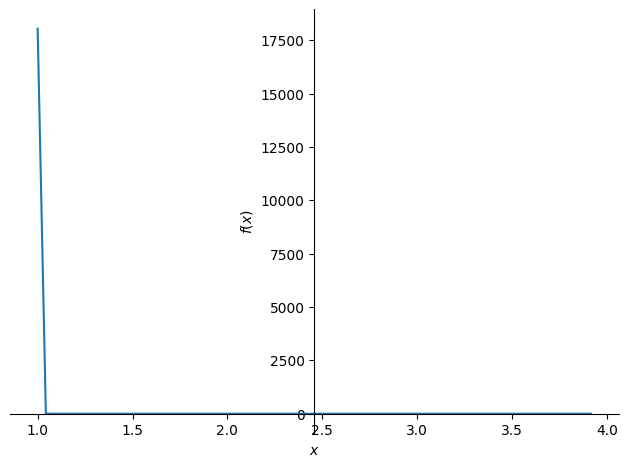

In [25]:
min = dist_matches_per_day.ppf(0.01, k, s, loc = loc, scale = scale)
max = dist_matches_per_day.ppf(0.99, k, s, loc = loc, scale = scale)
plot(f_matches_per_day, (x, min, max), nb_of_points=4000)

In [36]:
dist_matches_per_day.ppf(0.95, *params)

1.6757689220049836

95%概率内每天最多1.7场比赛

In [41]:
dist = dist_matches_per_day(*params)
number_of_matches_per_day_mean = dist.expect()
number_of_matches_per_day_mean

1.3292497874872218

每日比赛场次的数学期望为 1.329 场

# 技术支持

[ 0.66452924 -0.0956235 ]


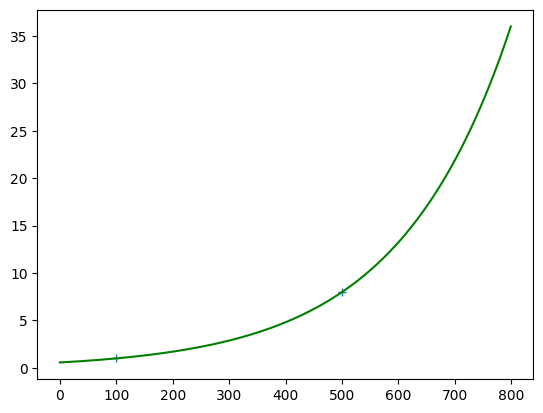

In [33]:
# 假设技术支持工时以参赛人数指数型上涨 y = a0e^(a1x)+a2
a1 = 0.005 # 陡峭系数

def target_func(x, a0, a2):
  return a0 * np.exp(a1*x) + a2

# 假设 100人比赛 1工时， 500人比赛8工时
tech_support_x = [100, 500]
tech_support_y = [1, 8]

fig, tech_ax = plt.subplots()
tech_ax.plot(tech_support_x, tech_support_y, '+')
para, cov = optimize.curve_fit(target_func, tech_support_x, tech_support_y)
print(para)
tech_x = range(0, 800)
tech_y = [target_func(a, *para) for a in tech_x]
tech_ax.plot(tech_x, tech_y, 'g')

In [29]:
a0 = 0.66452924
a2 = -0.0956235

f_tech_support = a0 * exp(a1 * x) + a2

f_tech_support

0.66452924*exp(0.005*x) - 0.0956235

In [42]:
# 比赛技术人员支持人数工时期望

sympy.integrate(f_number_of_participants * f_tech_support * number_of_matches_per_day_mean, (x, -oo, oo))

6.43165138321867

故，仅需6.4工时/天即可支持2023年比赛

# 实施人员

[ 2.16202468 -1.67673104]


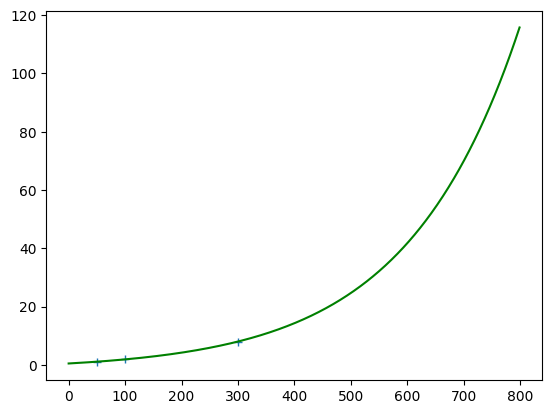

In [46]:
# 假设实施人员工时以参赛人数指数型上涨 y = a0e^(a1x)+a2
a1 = 0.005 # 陡峭系数

def target_func(x, a0, a2):
  return a0 * np.exp(a1*x) + a2

# 假设 50人比赛1工时，100人比赛2工时， 300人比赛8工时
tech_support_x = [50, 100, 300]
tech_support_y = [1, 2, 8]

fig, tech_ax = plt.subplots()
tech_ax.plot(tech_support_x, tech_support_y, '+')
para, cov = optimize.curve_fit(target_func, tech_support_x, tech_support_y)
print(para)
tech_x = range(0, 800)
tech_y = [target_func(a, *para) for a in tech_x]
tech_ax.plot(tech_x, tech_y, 'g')

In [47]:
a0, a2 = para

f_general_support = a0 * exp(a1 * x) + a2

f_general_support

2.16202468458986*exp(0.005*x) - 1.67673104373042

In [48]:
# 比赛实施人员工时期望

sympy.integrate(f_number_of_participants * f_general_support * number_of_matches_per_day_mean, (x, -oo, oo))

19.1099184813064

以8工时/天计，最多需3人即可支持2023年比赛